In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
# loading train balanced data
train_df = pd.read_csv("../data/train_smote_balanced.csv")
test_df = pd.read_csv("../data/test_unbalanced.csv")

In [3]:
#train_df.info()

## Training and Testing

In [4]:
# train data
X_train = train_df.drop('churn_label', axis=1)
y_train = train_df['churn_label']

# test data
X_test = test_df.drop('churn_label', axis=1)
y_test = test_df['churn_label']

## Correlation Heatmap

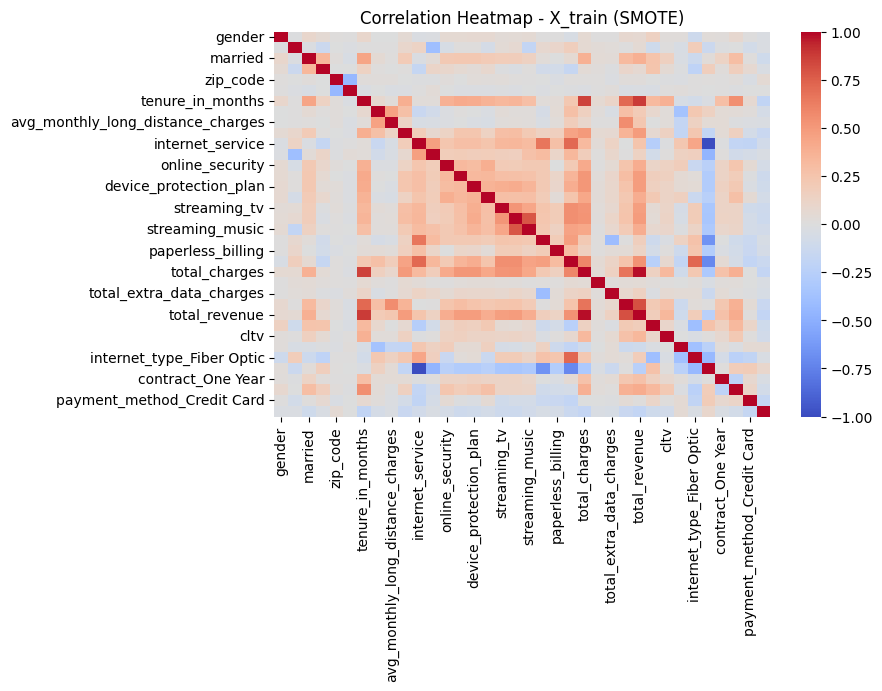

In [5]:
plt.figure(figsize=(8,5))
sns.heatmap(X_train.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap - X_train (SMOTE)")
plt.show()

In [6]:
# compute correlation matrix
correlation_matrix = X_train.corr()

# extract pairs with high correlation (abs value > 0.8)
high_corr_pairs = (
    correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape),
                                     k = 1).astype(bool))
    .stack()
    .reset_index()
)

# rename columns for clarity
high_corr_pairs.columns = ["Feature_1", "Feature_2", "Correlation"]

# filter for absolute correlations > 0.8
high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlation"].abs() > 0.8]

# Sort by absolute correlation
high_corr_pairs = high_corr_pairs.reindex(
    high_corr_pairs['Correlation'].abs().sort_values(ascending=False).index
)

# Display the result
#pd.set_option('display.max_rows', None)
print(high_corr_pairs)

                       Feature_1                  Feature_2  Correlation
325             internet_service  internet_type_No Internet    -1.000000
542                total_charges              total_revenue     0.977023
214             tenure_in_months              total_revenue     0.877533
210             tenure_in_months              total_charges     0.856404
575  total_long_distance_charges              total_revenue     0.811017


In [7]:
# drop these features
features_to_drop = [
    "internet_type_No Internet",
    "total_charges",
    "total_long_distance_charges",
    "tenure_in_months"
]

X_train.drop(columns=features_to_drop, inplace=True)
X_test.drop(columns=features_to_drop, inplace=True)

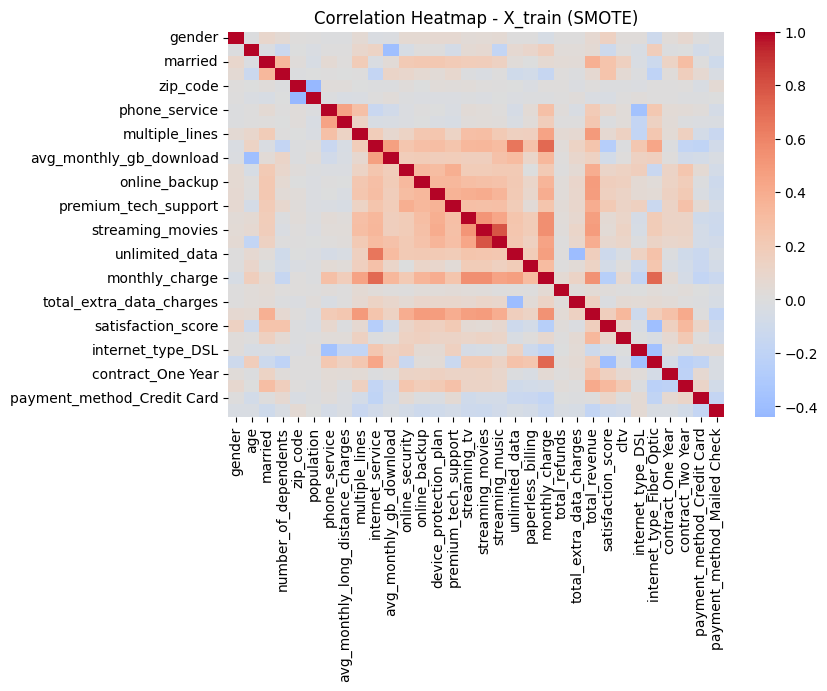

In [8]:
plt.figure(figsize=(8,5))
sns.heatmap(X_train.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap - X_train (SMOTE)")
plt.show()

## Logistic Regression

### Make Predictions on the Test Set

### Evaluate the Model